In [1]:
import numpy as np
from neuralStellar2 import *
import pymc3 as pm
import corner
import seaborn as sns
import theano.tensor as T
import theano
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
rc("font", family="serif", size=14)
import HBMplot

Using TensorFlow backend.
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#loading in NN
m1=NNmodel('evo',['mass','age','feh','MLT'],['radius','Teff','delnu'], Teff_scaling=5000)
m1.loadModel('Ran_files/big_grid_151/000_best_model.h5')
m1.getWeights()

Model: "neuralstellar"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense_77 (Dense)             (None, 128)               768       
_________________________________________________________________
dense_78 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_79 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_80 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_81 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_82 (Dense)             (None, 128)             

In [3]:
#loading in cluster csv
cluster_df = pd.read_csv('data_collection/NGC_6791/NGC_6791_cut.csv')
N = len(cluster_df.index)
print('There are {} stars in cluster.'.format(N))

There are 32 stars in cluster.


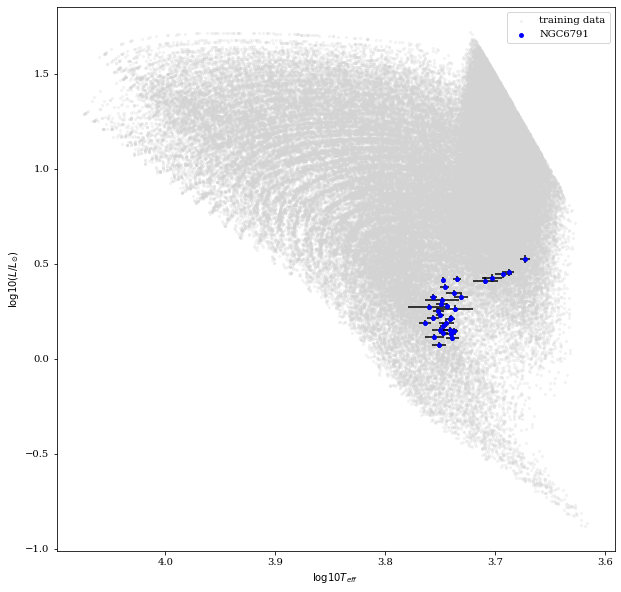

In [4]:
#showing cluster's location in HR
df = pd.read_csv('grid2_early.csv')
points = df[:100000]
HBMplot.plotClusterLocation(points, cluster_df, 'NGC6791')

## HBM!!!

In [5]:
model = pm.Model()
with model:
    Age_mu = pm.Deterministic('mean_age',pm.Beta('a',1.1,1.1)*4+8.452788-2)
    Age_sigma = pm.Lognormal('spread_age',T.log(0.15),0.4)
    feh_mu = pm.Deterministic('mean_feh',pm.Beta('e',1.1,1.1)*0.4+0.4-0.2)
    feh_sigma = pm.Lognormal('spread_feh',T.log(0.05),0.5)
    Y_mu = pm.Deterministic('mean_Y',pm.Beta('f',1.1,1.1)*0.04+0.30-0.02)
    Y_sigma = pm.Lognormal('spread_Y',T.log(0.01),0.5)
    MLT_mu = pm.Deterministic('mean_MLT',pm.Beta('g',1.1,1.1)*0.6+1.7)
    
    M = pm.Deterministic('mass', pm.Beta('d',1.1,1.1,shape=N)*(1.2-0.8)+0.8)
    Age = pm.Deterministic('age',pm.Normal('age_normal', 0, 1, shape=N)*Age_sigma+Age_mu)
    feh = pm.Deterministic('feh',pm.Normal('feh_normal', 0, 1, shape=N)*feh_sigma+feh_mu)
    Y = pm.Deterministic('Y',pm.Normal('Y_normal', 0, 1, shape=N)*Y_sigma+Y_mu)
    MLT = pm.Deterministic('MLT',T.ones(N)*MLT_mu)
    
    obs = pm.Deterministic('obs',m1.manualPredict(T.log10([M, Age, 10**feh, Y, MLT])))
    
    true_Teff = pm.Deterministic('true_Teff', 10**obs[1,:]*5000)
    true_L = pm.Deterministic('true_L', (10**obs[0,:])**2*(true_Teff/5776.02970722)**4)

In [6]:
#loading in track and print summary stats
trace = pm.load_trace(directory='pymc3_traces/NGC6791_4', model=model)
summary = pm.summary(trace, var_names=['mean_age','spread_age','mean_feh','spread_feh','mean_Y','spread_Y','mean_MLT'])
summary

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_age,7.985,0.476,7.204,8.979,0.141,0.103,11.0,11.0,13.0,35.0,1.25
spread_age,0.178,0.083,0.058,0.328,0.005,0.003,296.0,296.0,335.0,543.0,1.02
mean_feh,0.450,0.042,0.369,0.530,0.008,0.006,26.0,24.0,31.0,33.0,1.10
spread_feh,0.093,0.042,0.037,0.176,0.019,0.014,5.0,5.0,7.0,41.0,1.65
mean_Y,0.306,0.009,0.291,0.320,0.003,0.002,12.0,12.0,12.0,101.0,1.25
spread_Y,0.010,0.004,0.003,0.018,0.001,0.001,26.0,26.0,32.0,219.0,1.09
mean_MLT,1.775,0.077,1.700,1.924,0.020,0.014,15.0,15.0,20.0,30.0,1.14


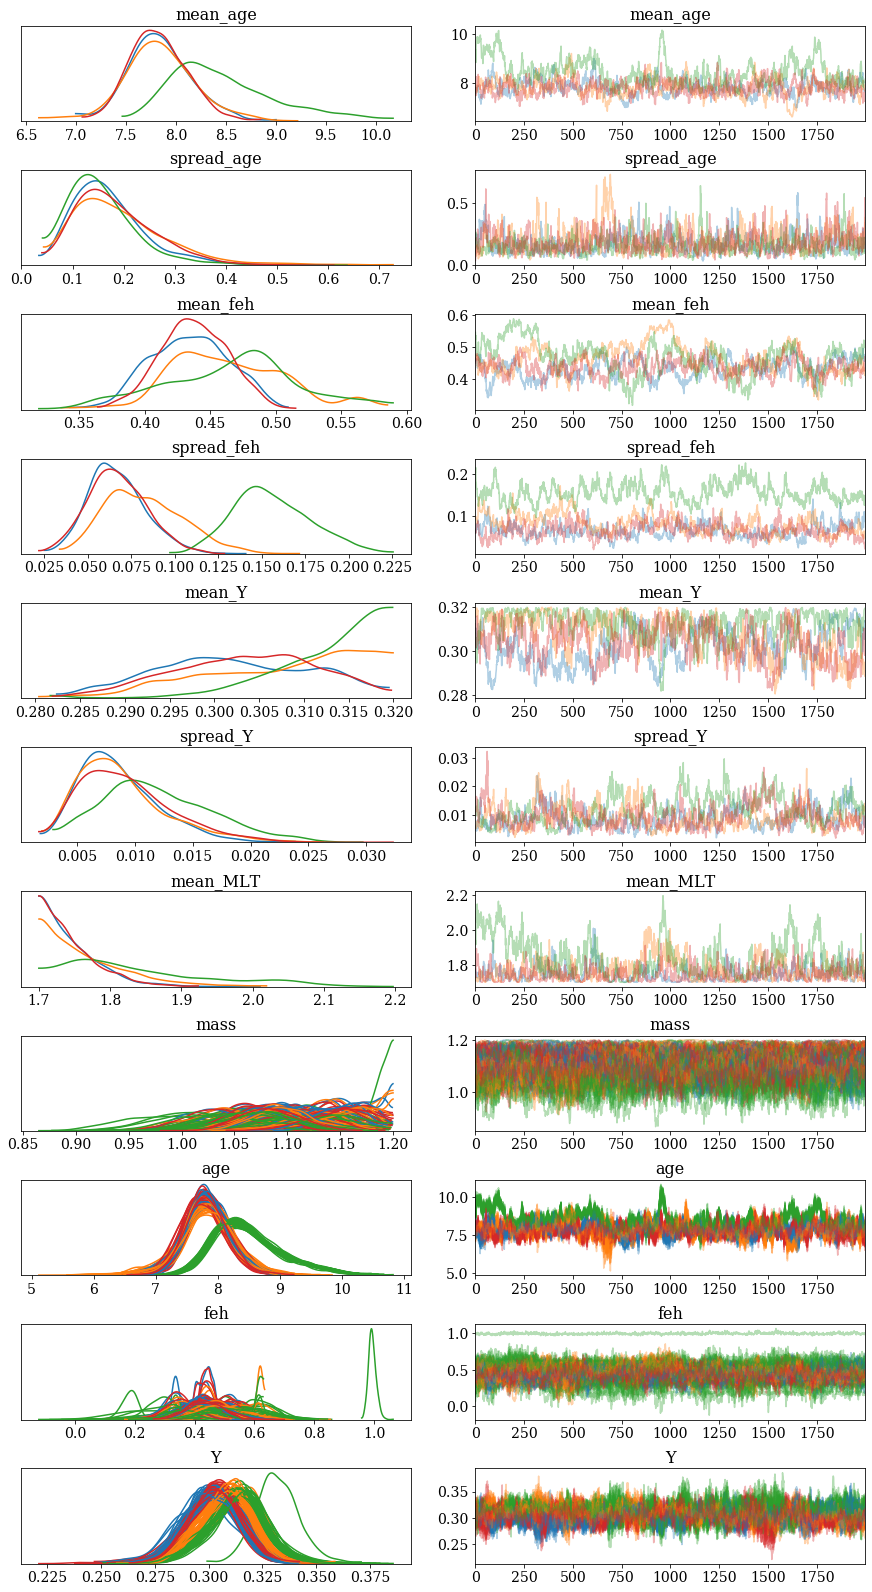

In [7]:
#trace plot
pm.plots.traceplot(trace,var_names=['mean_age','spread_age','mean_feh','spread_feh','mean_Y','spread_Y','mean_MLT','mass','age','feh','Y'],compact=True)
plt.show()

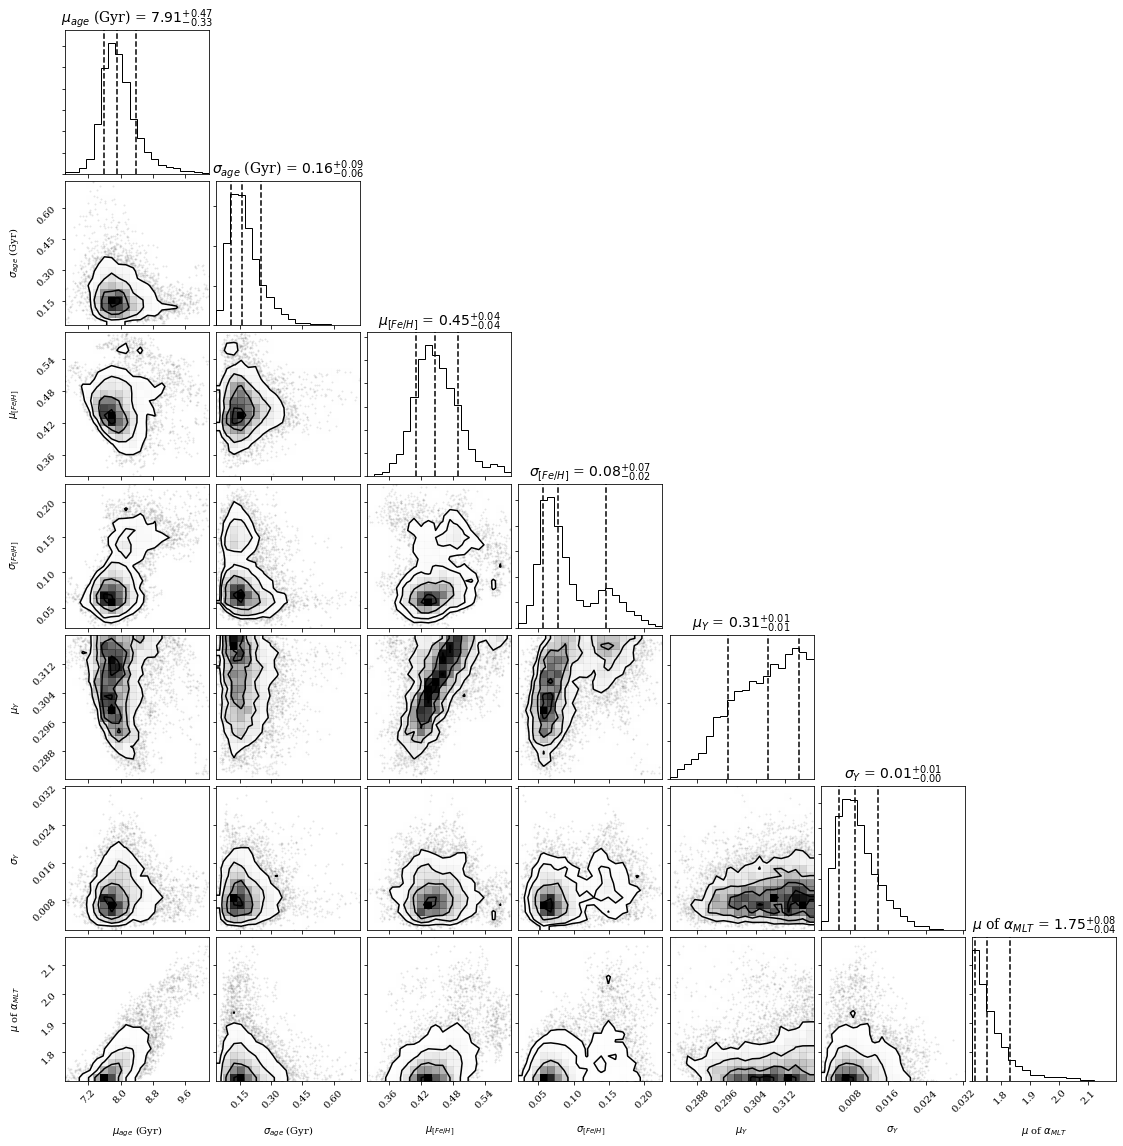

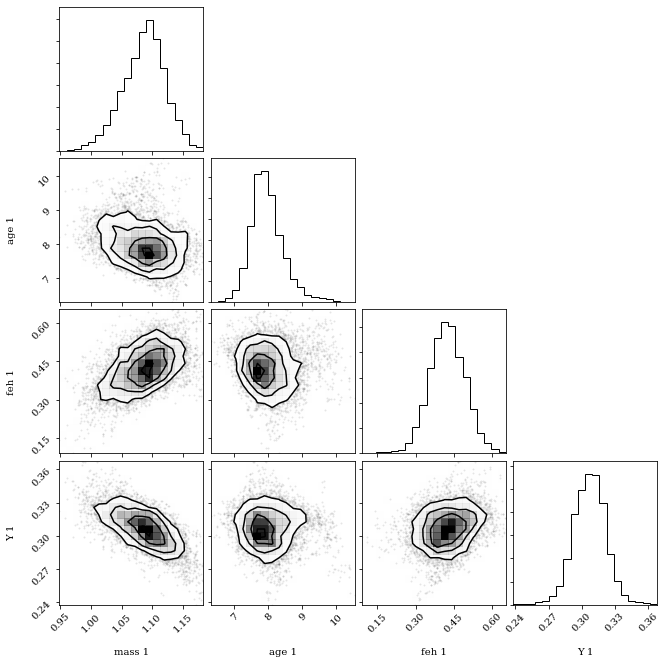

In [8]:
#corner plots
corner.corner(np.array([trace['mean_age'],trace['spread_age'],trace['mean_feh'],trace['spread_feh'],trace['mean_Y'],trace['spread_Y'],trace['mean_MLT']]).T,
              labels=[r'$\mu_{age}$ (Gyr)',r'$\sigma_{age}$ (Gyr)',r'$\mu_{[Fe/H]}$',r'$\sigma_{[Fe/H]}$',
                      r'$\mu_{Y}$',r'$\sigma_Y$',r'$\mu$ of $\alpha_{MLT}$'],
             quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 14})
plt.show()

corner_array=[]
labels=[]
for i,star in cluster_df.iterrows():
    corner_array.append(trace['mass'].T[i])
    corner_array.append(trace['age'].T[i])
    corner_array.append(trace['feh'].T[i])
    corner_array.append(trace['Y'].T[i])
    labels.append('mass '+str(i+1))
    labels.append('age '+str(i+1))
    labels.append('feh '+str(i+1))
    labels.append('Y '+str(i+1))
    if i==0:
        break

corner.corner(np.array(corner_array).T,labels=labels)
plt.show()

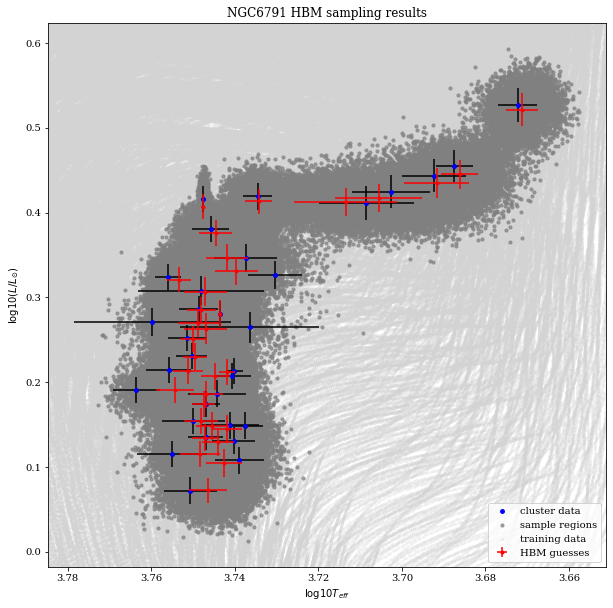

In [9]:
HBMplot.plotSample(trace, df, cluster_df, 'NGC6791 HBM sampling results', zoom_in=True)

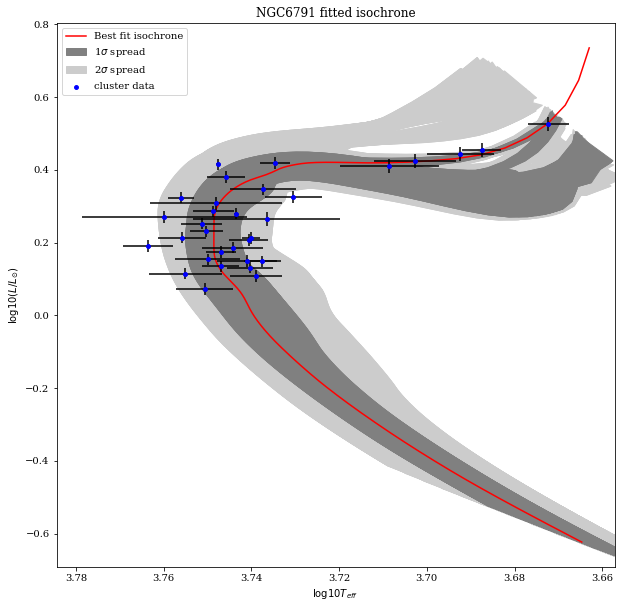

In [10]:
HBMplot.fittedIso(summary, m1.model, cluster_df, 'NGC6791 fitted isochrone')